In [57]:
import pandas as pd
from sklearn.model_selection import train_test_split, learning_curve, KFold, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
import numpy as np
import matplotlib.pyplot as plt
import optuna
import xgboost as xgb
from xgboost import XGBRegressor
import shap


In [58]:
df= pd.read_csv('../csv/after_cleaning/final.csv')
df.head()

,delegation,superficie,chambres,salle_de_bains,etat,etage,gouvernorat_ariana,gouvernorat_ben-arous,gouvernorat_la-manouba,gouvernorat_tunis,prix
0,21.0,62,1,1,10,1,0.0,0.0,0.0,1.0,259532.0
1,32.0,300,2,1,10,5,0.0,0.0,0.0,1.0,1208100.0
2,26.0,142,1,1,11,1,1.0,0.0,0.0,0.0,707302.0
3,29.0,281,3,2,11,8,0.0,0.0,0.0,1.0,1255227.0
4,26.0,153,1,1,10,1,1.0,0.0,0.0,0.0,687429.0


**train test split**

NOTE: Gradient Boosting Machines (XGBoost, LightGBM, CatBoost) – work well without scaling, as they rely on decision trees.


In [59]:
X= df.drop(columns='prix')

y= df['prix']

X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.2, random_state=42)

# XGBoost

**optuna optimizer**

Optuna finds the best parameters efficiently using a Tree-structured Parzen Estimator (TPE).


In [60]:
# def objective(trial):
#     params = {
#         'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
#         'max_depth': trial.suggest_int('max_depth', 3, 10),
#         'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
#         'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
#         'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0)
#     }

#     model = XGBRegressor(**params)
    
#     # Ensure X_train and y_train are correctly defined before running this function
#     score = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error', error_score='raise').mean()
#     return score

# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=50)

# print("Best parameters:", study.best_params)


In [61]:

param_grid = {
    'n_estimators': [100, 500, 1000],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.04, 0.1, 0.2, 0.5],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.5, 0.7, 1.0]
}

model = XGBRegressor()
grid_search = GridSearchCV(model, param_grid, cv=5, verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)


Fitting 5 folds for each of 405 candidates, totalling 2025 fits


[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.2s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.1s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.1s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.1s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.1s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, n_estima

In [62]:
# model= XGBRegressor(**study.best_params)
model= XGBRegressor(**grid_search.best_params_, early_stopping_rounds=5, random_state=42)

model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=False)

y_hat= model.predict(X_test)

In [63]:
mae = mean_absolute_error(y_test, y_hat)
mse = mean_squared_error(y_test, y_hat)
rmse = np.sqrt(mean_squared_error(y_test, y_hat))
mape=mean_absolute_percentage_error(y_test, y_hat)
r2 = r2_score(y_test, y_hat)


print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}")
print(f"R²: {r2}")

Mean Absolute Error (MAE): 107569.98507030285
Root Mean Squared Error (RMSE): 156758.56464056612
Mean Squared Error (MSE): 24573247588.170547
Mean Absolute Percentage Error (MAPE): 0.25317884163172916
R²: 0.7441465078314907


In [64]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Train metrics
mae_train = mean_absolute_error(y_train, y_train_pred)
mse_train = mean_squared_error(y_train, y_train_pred)
rmse_train = np.sqrt(mse_train)
mape_train = mean_absolute_percentage_error(y_train, y_train_pred)
r2_train = r2_score(y_train, y_train_pred)

# Test metrics
mae_test = mean_absolute_error(y_test, y_test_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
rmse_test = np.sqrt(mse_test)
mape_test = mean_absolute_percentage_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)

# Display results
print("===== Training Metrics =====")
print(f"Mean Absolute Error (MAE): {mae_train:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse_train:.4f}")
print(f"Mean Squared Error (MSE): {mse_train:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape_train:.4f}")
print(f"R²: {r2_train:.4f}")

print("\n===== Testing Metrics =====")
print(f"Mean Absolute Error (MAE): {mae_test:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse_test:.4f}")
print(f"Mean Squared Error (MSE): {mse_test:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape_test:.4f}")
print(f"R²: {r2_test:.4f}")


===== Training Metrics =====
Mean Absolute Error (MAE): 111797.8344
Root Mean Squared Error (RMSE): 193884.1972
Mean Squared Error (MSE): 37591081925.4659
Mean Absolute Percentage Error (MAPE): 0.2572
R²: 0.7084

===== Testing Metrics =====
Mean Absolute Error (MAE): 107569.9851
Root Mean Squared Error (RMSE): 156758.5646
Mean Squared Error (MSE): 24573247588.1705
Mean Absolute Percentage Error (MAPE): 0.2532
R²: 0.7441


**R² is around 74% , this means the model explains about 74% of the variance in apartment prices.
The higher the R², the better the model’s fit to the data.**

**k fold cross validation**

In [65]:

kf = KFold(n_splits=10, shuffle=True, random_state=42)
cv_scores = []

for train_idx, val_idx in kf.split(X_train):
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    # Train XGBoost model
    model = XGBRegressor(**grid_search.best_params_, early_stopping_rounds=5, random_state=42)
    model.fit(X_tr, y_tr, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=False)

    # Evaluate the model
    score = model.score(X_val, y_val)  # R² Score
    cv_scores.append(score)

# Print cross-validation results
print("Cross-validation scores:", cv_scores)
print("Mean CV score:", np.mean(cv_scores))


Cross-validation scores: [0.7231920384534593, 0.4795795481480728, 0.7713696770779588, 0.6528478742583028, 0.792490148938567, 0.6330669887021168, 0.7904040727344199, 0.8088150014385531, 0.6144120950112195, 0.7603845610039496]
Mean CV score: 0.7026562005766619


**around 70% accuracy**

**feature importance**

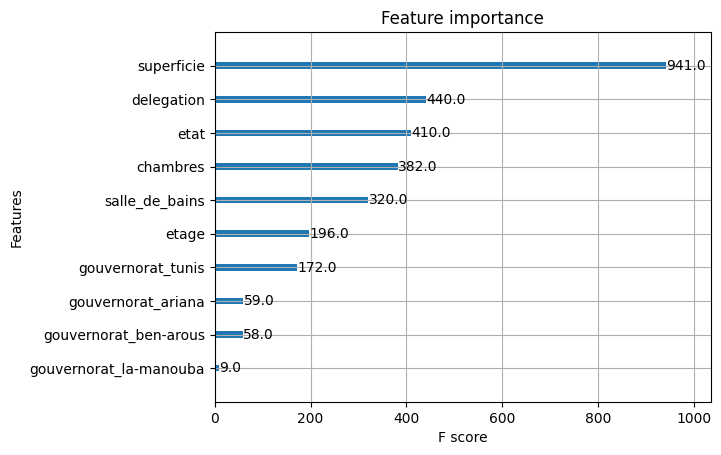

In [66]:
xgb.plot_importance(model)
plt.show()


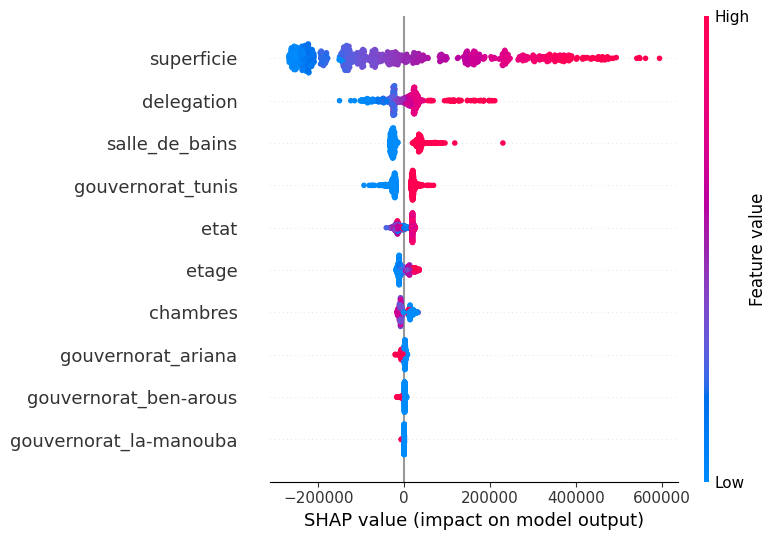

In [67]:
explainer = shap.Explainer(model)
shap_values = explainer(X_test)

shap.summary_plot(shap_values, X_test)


**learning curve**

dict_keys(['validation_0', 'validation_1'])


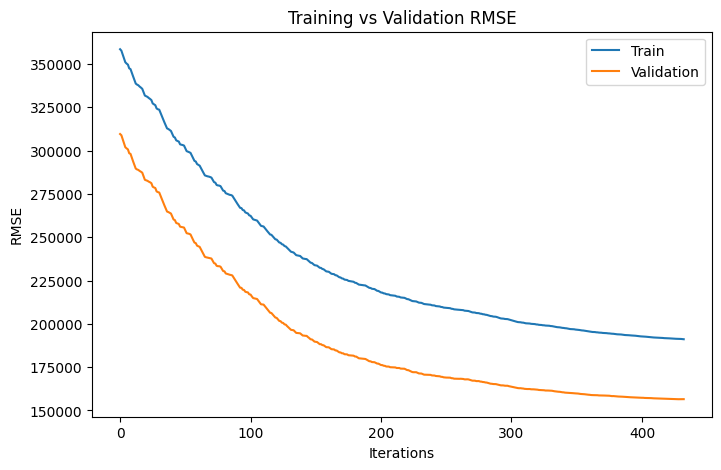

In [68]:
results = model.evals_result()

print(results.keys())
# Plot training vs validation loss
plt.figure(figsize=(8, 5))
plt.plot(results['validation_0']['rmse'], label='Train')
plt.plot(results['validation_1']['rmse'], label='Validation')
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.title('Training vs Validation RMSE')
plt.legend()
plt.show()
